In [3]:
!pip install pandas matplotlib seaborn tensorflow Pillow scikit-learn pyswarm


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4484 sha256=6726f0d01b452b8dd329610d951db0219d7fb3b12faffbcbd8d09f54c061fc6b
  Stored in directory: c:\users\35196\appdata\local\pip\cache\wheels\93\15\89\3970ef96abd6123028010a90f007c4e6a2bed700db0aa2d36a
Successfully built pyswarm


In [4]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re
from pyswarm import pso

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential

from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


from tensorflow.keras.preprocessing import image

In [5]:
# Definir o tamanho das imagens 
IMAGE_WIDTH = 224    
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Caminho das imagens
base_path = "C:/Users/35196/Documents/archive/garbage_classification"

augmented_dir = "C:/Users/35196/Documents/archive/garbage_classification/augmentation"


# 4 classes
categories = {0: 'biological', 1: 'clothes', 2: 'shoes', 3: 'trash'}

In [6]:
# Função que tranforma isto "/paper104.jpg" em isto "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search(r"\d", x).start()] + '/' + x)


    return df

# Lista com os filenames do dataset
filenames_list = []

# Lista para guardar as categorias
categories_list = []

# Preenche as listas
# Corrige a construção do caminho
for category in categories:
    filenames = os.listdir(os.path.join(base_path, categories[category]))
    
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

# Atribui ao dataframe os valores
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

# Chama a função para adicionar o nome na directoria
df = add_class_name_prefix(df, 'filename')

# Baralha o dataframe
df = df.sample(frac=1).reset_index(drop=True)




print('Número total de imagens do Dataset = ' , len(df))

Número total de imagens do Dataset =  10425


In [7]:
# Mostra as 5 primeiras
df.head()

,filename,category
0,shoes/shoes258.png,2
1,biological/biological717.jpg,0
2,shoes/shoes2385.png,2
3,shoes/shoes225.jpg,2
4,clothes/clothes1223.jpg,1


shoes/shoes1018.jpg


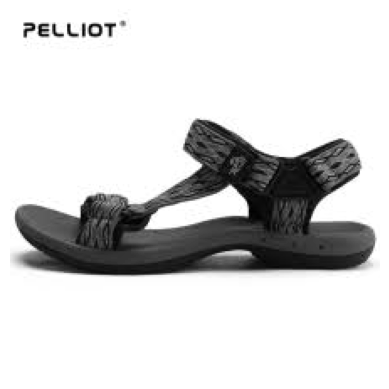

In [8]:
# Seleciona uma linha aleatória
random_row = random.randint(0, len(df) - 1)

sample = df.iloc[random_row]

# Carrega a imagem em escala de cinza
randomimage = image.load_img(os.path.join(base_path, sample['filename']), color_mode='grayscale')

# Exibe o nome do arquivo e a imagem
print(sample['filename'])
plt.imshow(randomimage, cmap='gray')
plt.axis('off')  #Não ter eixos para ser mais facil perceber a imagem
plt.show()  #  Mostra a imagem

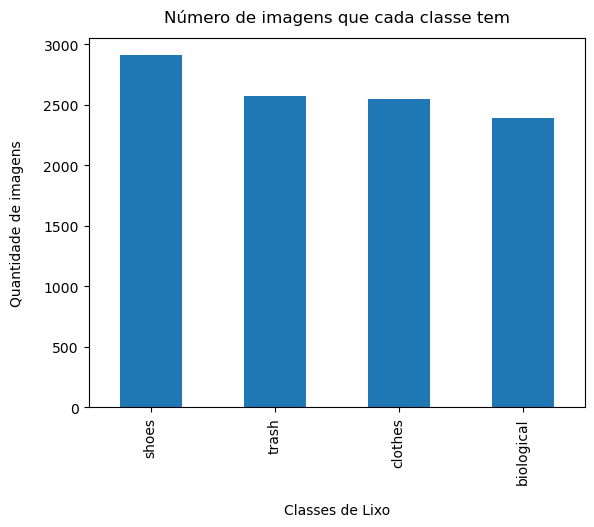

In [9]:
# Mostra quantas imagens cada classe tem. Dá jeito para confirmar que as imagens estão a ser todas reconhecidas
df_visualization = df.copy()

df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Classes de Lixo", labelpad=14)
plt.ylabel("Quantidade de imagens", labelpad=14)
plt.title("Número de imagens que cada classe tem", y=1.02);

In [10]:
# Muda as categorias de numeros para nome
df["category"] = df["category"].replace(categories) 

# Dividimos o nosso dataset em treino, validação e teste, de modo a ter dados mais fidedignos e não
# tão tendenciosos. 80% para treino, 10% para validação e 10% para teste
# Ao dividir em validação permite-nos ver se o modelo está em overfitting, gera-nos outros dados que não
# os de treino
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True) 
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0] 
total_validate = validate_df.shape[0] 

print('Num Imagens de Treino = ', total_train , '  Num Imagens de Validação = ', total_validate, '  Num Imagens de Teste = ', test_df.shape[0])

from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size=64
# Gerador de aumento de dados para o treino
train_datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1.0/255  # Normalizar os valores de pixel para [0, 1]
)

# Gerador para validação (sem aumento de dados)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Criar geradores de treino e validação
train_generator = train_datagen.flow_from_dataframe(
    train_df,  # DataFrame de treino
    directory=base_path,  # Caminho das imagens
    x_col='filename',  # Coluna com os caminhos das imagens
    y_col='category',  # Coluna com os rótulos
    target_size=IMAGE_SIZE,  # Tamanho das imagens (ex.: (224, 224))
    class_mode='categorical',  # Rótulos no formato one-hot
    batch_size=batch_size  # Tamanho do lote
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,  # DataFrame de validação
    directory=base_path,  # Caminho das imagens
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# Variáveis úteis
steps_per_epoch = len(train_df) // batch_size  # Número de lotes por época
total_validate = len(validate_df)


Num Imagens de Treino =  8340   Num Imagens de Validação =  1042   Num Imagens de Teste =  1043
Found 8340 validated image filenames belonging to 4 classes.
Found 1042 validated image filenames belonging to 4 classes.


In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam

num_classes = df['category'].nunique()

def objective_function(params):
    # Hiperparâmetros
    lr, neurons = params
    neurons = int(neurons)

    # Construir o modelo
    model = Sequential()
    model.add(Input(shape=(224, 224, 3)))
    model.add(Conv2D(8, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(neurons, kernel_regularizer=l2(0.001)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))

    # Compilar o modelo
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )

    # Treinar o modelo
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=3,  # Treinamento breve para avaliação
        steps_per_epoch=total_train // batch_size,
        validation_steps=total_validate // batch_size,
        verbose=1
    )

    # Retornar a acurácia de validação (negativa porque PSO minimiza)
    val_accuracy = history.history['val_categorical_accuracy'][-1]
    return -val_accuracy



In [12]:
num_classes = df['category'].nunique()
print("Número de classes:", num_classes)

Número de classes: 4


In [13]:
# Espaço de busca
lb = [1e-5, 32]  # Limite inferior
ub = [1e-2, 256]  # Limite superior

# Executar o PSO
best_params, best_score = pso(objective_function, lb, ub, swarmsize=5, maxiter=5)

# Exibir os melhores parâmetros
print("Melhor taxa de aprendizado:", best_params[0])
print("Melhor número de neurônios:", int(best_params[1]))
print("Melhor acurácia de validação:", -best_score)


C:\Users\35196\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
130/130 ━━━━━━━━━━━━━━━━━━━━ 124s 932ms/step - categorical_accuracy: 0.4298 - loss: 49.9113 - val_categorical_accuracy: 0.4141 - val_loss: 4.3793
Epoch 2/3
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - categorical_accuracy: 0.4062 - loss: 4.0996 - val_categorical_accuracy: 0.2222 - val_loss: 4.2566
Epoch 3/3


C:\Users\35196\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


130/130 ━━━━━━━━━━━━━━━━━━━━ 120s 921ms/step - categorical_accuracy: 0.4555 - loss: 3.5515 - val_categorical_accuracy: 0.5049 - val_loss: 2.3712
Epoch 1/3
130/130 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - categorical_accuracy: 0.3593 - loss: 111.8422 - val_categorical_accuracy: 0.2793 - val_loss: 11.0021
Epoch 2/3
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.3906 - loss: 10.8809 - val_categorical_accuracy: 0.2778 - val_loss: 10.8727
Epoch 3/3
130/130 ━━━━━━━━━━━━━━━━━━━━ 128s 982ms/step - categorical_accuracy: 0.4208 - loss: 8.4299 - val_categorical_accuracy: 0.4805 - val_loss: 3.6007
Epoch 1/3
130/130 ━━━━━━━━━━━━━━━━━━━━ 131s 997ms/step - categorical_accuracy: 0.5325 - loss: 10.1171 - val_categorical_accuracy: 0.6055 - val_loss: 1.3583
Epoch 2/3
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.6250 - loss: 1.3107 - val_categorical_accuracy: 0.6111 - val_loss: 1.3452
Epoch 3/3
130/130 ━━━━━━━━━━━━━━━━━━━━ 129s 990ms/step - categorical_accuracy: 0.6611

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam

input_shape = (224, 224, 3)

best_lr = best_params[0]
best_neurons = int(best_params[1])

model = Sequential()

model.add(Conv2D(8, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(best_neurons, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(num_classes, activation='softmax'))

# Compilar com os melhores hiperparâmetros
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=best_lr),
              metrics=['categorical_accuracy'])

# Resumo do modelo
model.summary()


C:\Users\35196\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 224, 224, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 224, 224, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_60 (Activation)      │ (None, 224, 224, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 112, 112, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 112, 112, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_61 (Activation)      │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 56, 56, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_62 (Activation)      │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 191)            │     4,791,999 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 191)            │           764 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_63 (Activation)      │ (None, 191)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 191)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 4)              │           768 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,799,787 (18.31 MB)

 Trainable params: 4,799,293 (18.31 MB)

 Non-trainable params: 494 (1.93 KB)

In [17]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]



In [19]:
# Muda as categorias de numeros para nome
df["category"] = df["category"].replace(categories) 

# Dividimos o nosso dataset em treino, validação e teste, de modo a ter dados mais fidedignos e não
# tão tendenciosos. 80% para treino, 10% para validação e 10% para teste
# Ao dividir em validação permite-nos ver se o modelo está em overfitting, gera-nos outros dados que não
# os de treino
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True) 
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0] 
total_validate = validate_df.shape[0] 

print('Num Imagens de Treino = ', total_train , '  Num Imagens de Validação = ', total_validate, '  Num Imagens de Teste = ', test_df.shape[0])

Num Imagens de Treino =  8340   Num Imagens de Validação =  1042   Num Imagens de Teste =  1043


In [21]:
batch_size=64

train_datagen = image.ImageDataGenerator(
    
    ###  Augmentation Start  ###
    
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2
    
    ##  Augmentation End  ###
)



train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)
steps_per_epoch = len(train_df) // batch_size  # Número de batches
total_steps = steps_per_epoch * batch_size 


print(f"Total training samples: {len(train_df)}")
print(f"Total de exemplos processados por época: {total_steps}")

Found 8340 validated image filenames belonging to 4 classes.
Total training samples: 8340
Total de exemplos processados por época: 8320


In [23]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1042 validated image filenames belonging to 4 classes.


In [25]:
EPOCHS = 20
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\35196\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - categorical_accuracy: 0.6190 - loss: 1.4651 - val_categorical_accuracy: 0.5264 - val_loss: 1.5954
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - categorical_accuracy: 0.7500 - loss: 1.1478 - val_categorical_accuracy: 0.6111 - val_loss: 1.4364
Epoch 3/20


C:\Users\35196\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


130/130 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - categorical_accuracy: 0.7461 - loss: 0.9890 - val_categorical_accuracy: 0.7402 - val_loss: 0.9707
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step - categorical_accuracy: 0.7969 - loss: 0.8232 - val_categorical_accuracy: 0.9444 - val_loss: 0.6639
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - categorical_accuracy: 0.7580 - loss: 0.8931 - val_categorical_accuracy: 0.7588 - val_loss: 0.8434
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 616us/step - categorical_accuracy: 0.7656 - loss: 0.8737 - val_categorical_accuracy: 0.7778 - val_loss: 0.7734
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.


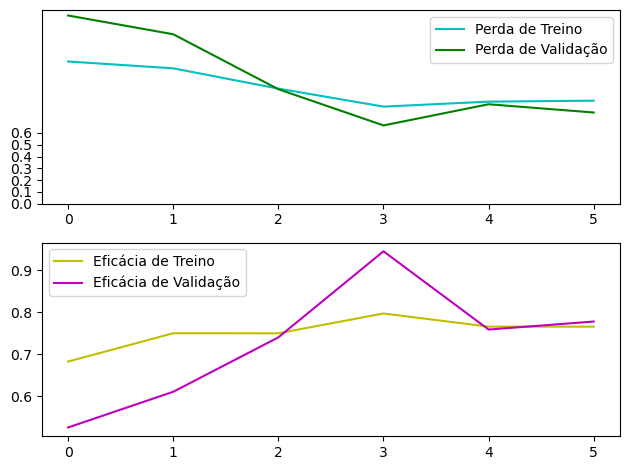

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='c', label="Perda de Treino")
ax1.plot(history.history['val_loss'], color='g', label="Perda de Validação")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='y', label="Eficácia de Treino")
ax2.plot(history.history['val_categorical_accuracy'], color='m',label="Eficácia de Validação")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [29]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 1043 validated image filenames belonging to 4 classes.


In [31]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate(test_generator, steps=nb_samples)

print('Eficácia de teste = ',  round((accuracy * 100),2 ), '% ') 

   6/1043 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - categorical_accuracy: 0.4333 - loss: 1.1716    

C:\Users\35196\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1043/1043 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - categorical_accuracy: 0.7571 - loss: 0.9162
Eficácia de teste =  75.26 % 


In [33]:
# No inicio definimos as nossas proprias classes, no entanto, o gerador de treino gera as suas proprias
# Logo estas têm diferentes números para as nossas categorias/classes
# As previsões serão feitas com base no numero das classes do gerador

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'biological', 1: 'clothes', 2: 'shoes', 3: 'trash'}


1043/1043 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
              precision    recall  f1-score   support

  biological       0.88      0.77      0.82       244
     clothes       0.69      0.77      0.73       253
       shoes       0.79      0.55      0.65       296
       trash       0.70      0.96      0.81       250

    accuracy                           0.75      1043
   macro avg       0.77      0.76      0.75      1043
weighted avg       0.77      0.75      0.75      1043



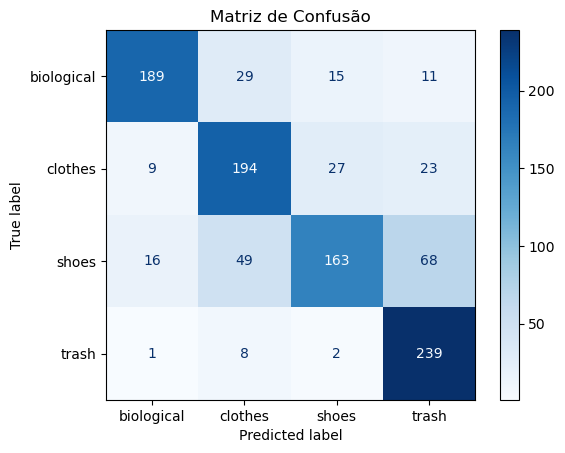

In [35]:
# Mete na previsão do modelo os nossos dados de teste
preds = model.predict(test_generator, steps=len(test_generator))

# Vais buscar o NUMERO da categoria com a probabilidade de previsão mais alta
preds_classes = preds.argmax(axis=1)  # Armazenar as classes previstas como índices

# Converter índices para nomes das classes usando o dicionário
preds_labels = [gen_label_map[item] for item in preds_classes]  # Mapeia índices para nomes

# Converte o dataframe para uma matriz
labels = test_df['category'].to_numpy()  # Assume que isso é uma lista de strings

# Exibe o relatório de classificação
print(classification_report(labels, preds_labels))

# Criar a matriz de confusão
cm = confusion_matrix(labels, preds_labels)  

# Exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gen_label_map.values())
disp.plot(cmap=plt.cm.Blues)  
plt.title('Matriz de Confusão')
plt.show()
